### Scrape Location-based data
Knowledge Source: https://www.youtube.com/watch?v=8Uxxu0-dAKQ

In [1]:
# Environment setup
import os
import sys
import warnings
import glob
import numpy as np
root_dir = os.path.join(os.getcwd(), '..')
sys.path.append(root_dir)
warnings.filterwarnings('ignore')
import requests
import pandas as pd
from datetime import datetime
from geopy.geocoders import Nominatim

# initialize Nominatim API 
geolocator = Nominatim(user_agent="geoapiExercises")

# Graph
import matplotlib.pyplot as plt


In [2]:
# input parameters: User Geo Location
lat = '45.80575529738116'
lon = '15.980034797732543'


# Get city name
location = geolocator.reverse(lat+","+lon, language='en')
country_code = location.raw['address']['country_code']
city = location.raw['address']['county']

### Scrape Wolt Data

In [27]:
## FETCH STORE NAME
def data_fetch(lat,lon):
# fetch data
    url = "https://restaurant-api.wolt.com/v1/pages/restaurants?lat="+lat+"&lon="+lon

    r = requests.get(url)
    print(r.status_code)

    data = r.json()
    # print(data)

    # INFO BREAKDOWN

    ## Scrape Date
    d = str(data['created']['$date'])+'0000'
    d = int(d[:10])
    scrape_date = datetime.fromtimestamp(d).strftime('%Y-%m-%d')

    ## store_name, delivery_fee
    store_name = []
    dfee = []
    store_lat = []
    store_lon = []

    for i in data['sections'][0]['items']:
        store_name.append(i['venue']['name'])
        dfee.append(i['venue']['delivery_price'])
        store_lat.append(i['venue']['location'][1])
        store_lon.append(i['venue']['location'][0])

    df = pd.DataFrame({
        'date' : scrape_date,
        'user_country': country_code,
        'user_city': city,
        'user_lat' : lat,
        'user_lon': lon,
        'store_name': store_name,
        'store_lat': store_lat,
        'store_lon': store_lon,
        'dfee' : dfee})
    
    return df

def distance_cal(df):
# calculate distance between user locations and store locations
    # change datatype
    df[['user_lat','user_lon']] = df[['user_lat','user_lon']].astype(float)

    # convert lat/lon to radians
    df['user_lat_r'] = np.radians(df.user_lat)
    df['user_lon_r'] = np.radians(df.user_lon)
    df['store_lat_r'] = np.radians(df.store_lat)
    df['store_lon_r'] = np.radians(df.store_lon)

    df['a'] = np.sin((df.store_lat_r-df.user_lat_r)/2.0)**2 + np.cos(df.user_lat_r) * np.cos(df.store_lat_r) * np.sin((df.store_lon_r-df.user_lon_r)/2.0)**2

    df['distance'] = 6373 * 2 * np.arcsin(np.sqrt(df['a']))

    df.drop(['user_lat','user_lon','user_lat_r','user_lon_r','store_lat_r','store_lon_r','a'],axis=1,inplace=True)

    return df

def output_file(df):
# get and save output files
    ### Distance Graph ###

    # Before creating the graph, we need to change dfee column to float dtype

    df['dfee'] = df['dfee'].apply(lambda x: x.lstrip('HRK'))
    df['dfee'] = df['dfee'].astype(float)

    # Create graphs
    df_test = df[df['dfee']!=0]
    df_test = df_test[['dfee','distance']].groupby('distance',as_index=False).mean()
    df_test.columns = ['distance','dfee']
    fig = df_test.plot(x = 'distance',y = 'dfee',figsize = (10,8))

    # save graphs
    os.chdir('/Volumes/GoogleDrive-114473456834176483322/My Drive/Resume/portfolio/web_scraper')
    fig.figure.savefig(os.path.join('output','DT_graph_geo_'+lon+'_'+lat+'.png'))

    # Get distance tiers data in a table
    df_distance_tiers = df_test.groupby('dfee', as_index = False).max()
    df_distance_tiers.to_csv(os.path.join('output',"df_distance_tiers_geo_"+lon+"_"+lat+"_.csv"))


200


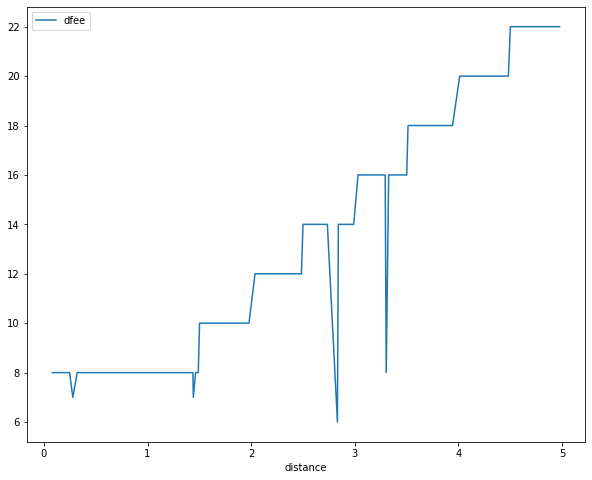

In [29]:
df = data_fetch(lat,lon)
df = distance_cal(df)
output_file(df)